In [2]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter


import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy
import pyarrow

import inference
import learning
import torch

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pymc3 as pm

import statsmodels.api as sm

import patch
import kinematics

In [3]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [4]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")
    
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

# Choose Valid Sessions

In [6]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

# Time in Patch

In [5]:
def DeleteRows(mouse_pos):
    mouse_pos_reset = mouse_pos.reset_index()


    grouping_var = mouse_pos_reset.groupby(mouse_pos_reset.index // 5).ngroup()
    agg_dict = {col: 'mean' for col in mouse_pos_reset.columns if col != 'time'}
    agg_dict['time'] = 'last'

    mouse_pos_grouped = mouse_pos_reset.groupby(grouping_var).agg(agg_dict)

    mouse_pos_grouped.set_index('time', inplace=True)
    mouse_pos_grouped.index.name = None
    
    return mouse_pos_grouped

In [6]:
def AtGate(mouse_pos, r=5):
    gate = [1233, 588]
    distance = np.sqrt((mouse_pos['smoothed_position_x'] - gate[0]) ** 2 + (mouse_pos['smoothed_position_y'] - gate[1]) ** 2)

    return mouse_pos.iloc[np.where(distance < r)].index

In [7]:
def MoveWheel(start, end, patch = 'Patch1', interval_seconds = 10):
    if patch == 'Patch1': encoder = api.load(root, exp02.Patch1.Encoder, start=start, end=end)
    else: encoder = api.load(root, exp02.Patch2.Encoder, start=start, end=end)
    
    w = -distancetravelled(encoder.angle).to_numpy()
    dw = np.concatenate((np.array([0]), w[:-1]- w[1:]))
    encoder['Distance'] = pd.Series(w, index=encoder.index)
    encoder['DistanceChange'] = pd.Series(dw, index=encoder.index)
    encoder['DistanceChange'] = encoder['DistanceChange'].rolling('10S').mean()
    encoder['Move'] = np.where(encoder.DistanceChange > 0.001, 1, 0)
    
    if interval_seconds < 0.01: return encoder
    groups = encoder['Move'].ne(encoder['Move'].shift()).cumsum()
    zeros_groups = encoder[encoder['Move'] == 0].groupby(groups)['Move']
    for name, group in zeros_groups:
        duration = group.index[-1] - group.index[0]
        if duration < pd.Timedelta(seconds=interval_seconds): encoder.loc[group.index, 'Move'] = 1
    return encoder

In [8]:
def Visits(mouse_pos, patch = 'Patch1', pre_period_seconds = 10):
    encoder = MoveWheel(mouse_pos.index[0], mouse_pos.index[-1], patch = patch)
        
    entry = AtGate(mouse_pos)
        
    Visits = {'start':[],'end':[], 'distance':[], 'duration':[], 'speed':[], 'acceleration':[], 'weight':[],'state':[], 'entry':[]}
    
    groups = encoder['Move'].ne(encoder['Move'].shift()).cumsum()
    visits = encoder[encoder['Move'] == 1].groupby(groups)['Move']
    for name, group in visits:
        Visits['start'].append(group.index[0])
        Visits['end'].append(group.index[-1])
        Visits['duration'].append((group.index[-1]-group.index[0]).total_seconds())
        Visits['distance'].append(encoder.loc[group.index[0], 'Distance']-encoder.loc[group.index[-1], 'Distance'])
            
        pre_end = group.index[0]
        pre_start = pre_end - pd.Timedelta(seconds = pre_period_seconds)
        if pre_start < mouse_pos.index[0]: pre_start = mouse_pos.index[0]
            
        pre_visit_data = mouse_pos.loc[pre_start:pre_end]
        
        Visits['speed'].append(pre_visit_data['smoothed_speed'].mean())
        Visits['acceleration'].append(pre_visit_data['smoothed_acceleration'].mean())
        Visits['weight'].append(pre_visit_data['weight'].mean())
        Visits['state'].append(pre_visit_data['states'].value_counts().idxmax())
            

        index = entry.searchsorted(pre_end, side='left') - 1
        index = max(index, 0)
        Visits['entry'].append((pre_end - entry[index]).total_seconds())
    
    return pd.DataFrame(Visits)

In [9]:
def VisitIntervals(Visits_Patch1, Visits_Patch2):
        Patch1, Patch2 = True, True
        if len(Visits_Patch1) == 0: Patch1 = False
        if len(Visits_Patch2) == 0: Patch2 = False
        
        Visits_Patch1 = Visits_Patch1.copy()
        Visits_Patch2 = Visits_Patch2.copy()
        
        Visits_Patch1['PelletsInLastVisitSelf'] = 0
        Visits_Patch1['PelletsInLastVisitOther'] = 0
        Visits_Patch1['IntervalLastVisit'] = 0
        for i in range(1,len(Visits_Patch1)):
                start, end = Visits_Patch1.start[i-1], Visits_Patch1.end[i-1]
                
                pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
                Visits_Patch1.loc[i, 'PelletsInLastVisitSelf'] = len(pellets_patch1)
                Visits_Patch1.loc[i, 'IntervalLastVisit'] = (Visits_Patch1.start[i] - end).total_seconds()
                
                if Patch2:
                        prior_timestamps = Visits_Patch2[Visits_Patch2['end'] < Visits_Patch1.start[i]]
                        if not prior_timestamps.empty:
                                start_, end_ = prior_timestamps.iloc[-1]['start'], prior_timestamps.iloc[-1]['end']
                                pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start_, end=end_)
                                Visits_Patch1.loc[i, 'PelletsInLastVisitOther'] = len(pellets_patch2)
                                if end < end_: Visits_Patch1.loc[i, 'IntervalLastVisit'] = (Visits_Patch1.start[i] - end_).total_seconds()
        
                
        Visits_Patch2['PelletsInLastVisitSelf'] = 0
        Visits_Patch2['PelletsInLastVisitOther'] = 0
        Visits_Patch2['IntervalLastVisit'] = 0
        for i in range(1,len(Visits_Patch2)):
                start, end = Visits_Patch2.start[i-1], Visits_Patch2.end[i-1]

                pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
                Visits_Patch2.loc[i, 'PelletsInLastVisitSelf'] = len(pellets_patch2)
                Visits_Patch2.loc[i, 'IntervalLastVisit'] = (Visits_Patch2.start[i] - end).total_seconds()
                
                if Patch1:
                        prior_timestamps = Visits_Patch1[Visits_Patch1['end'] < Visits_Patch2.start[i]]
                        if not prior_timestamps.empty: 
                                start_, end_ = prior_timestamps.iloc[-1]['start'], prior_timestamps.iloc[-1]['end']
                                pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start_, end=end_)
                                Visits_Patch2.loc[i, 'PelletsInLastVisitOther'] = len(pellets_patch1)
                                if end < end_: Visits_Patch2.loc[i, 'IntervalLastVisit'] = (Visits_Patch2.start[i] - end_).total_seconds()

        return Visits_Patch1, Visits_Patch2

In [37]:
dfs = []
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(i)
    print(title)
    Visits_Patch1 = pd.read_parquet(title+'Visit1.parquet', engine='pyarrow')
    Visits_Patch2 = pd.read_parquet(title+'Visit2.parquet', engine='pyarrow')
    dfs.append(Visits_Patch1)
    dfs.append(Visits_Patch2)
    
VISIT = pd.concat(dfs, ignore_index=False)
VISIT = VISIT[VISIT['distance'] >= 0.1]
VISIT['interc'] = 1

ShortSession0
ShortSession1
ShortSession2
ShortSession3
ShortSession4
ShortSession5
ShortSession6
ShortSession7
ShortSession8
ShortSession9
ShortSession10
ShortSession11


# Gamma

                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                  425
Model:                            GLM   Df Residuals:                      417
Model Family:                   Gamma   Df Model:                            7
Link Function:                    Log   Scale:                         0.91041
Method:                          IRLS   Log-Likelihood:                -2085.5
Date:                Mon, 11 Mar 2024   Deviance:                       296.15
Time:                        14:16:42   Pearson chi2:                     380.
No. Iterations:                    44   Pseudo R-squ. (CS):            0.06760
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed                     

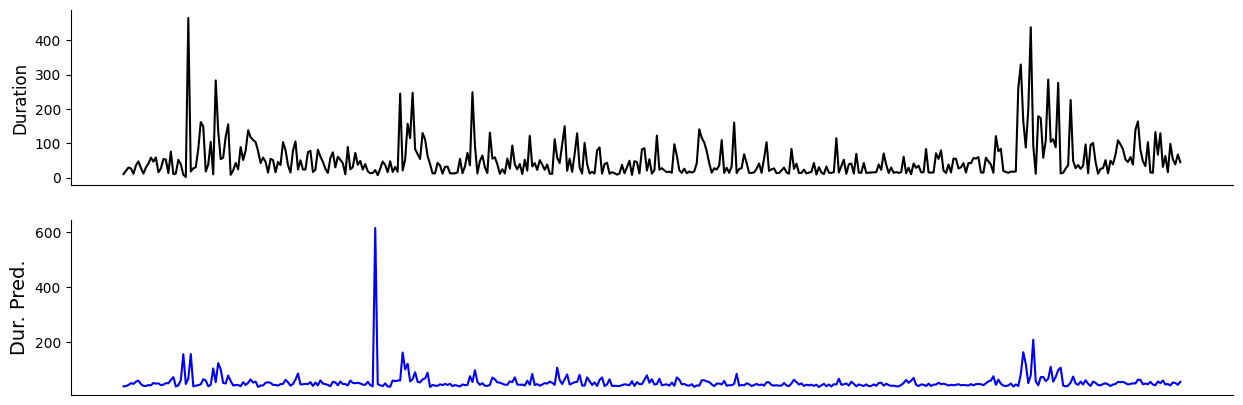

                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                  425
Model:                            GLM   Df Residuals:                      417
Model Family:                   Gamma   Df Model:                            7
Link Function:                    Log   Scale:                          1.0489
Method:                          IRLS   Log-Likelihood:                -2808.2
Date:                Mon, 11 Mar 2024   Deviance:                       451.55
Time:                        14:16:42   Pearson chi2:                     437.
No. Iterations:                    47   Pseudo R-squ. (CS):            0.08494
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed                     

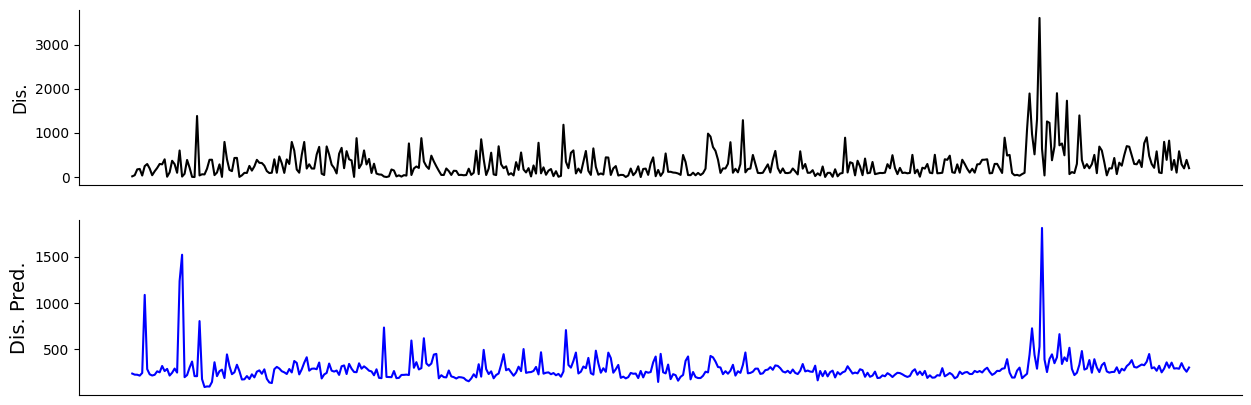

In [44]:
X = VISIT[['speed','acceleration', 'weight','PelletsInLastVisitSelf', 'PelletsInLastVisitOther', 'IntervalLastVisit' ,'entry']]
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index = X.index, columns = X.columns)
X['interc'] = 1

# Duration
Y = VISIT['duration']

model = sm.GLM(Y, X, family=sm.families.Gamma(sm.families.links.Log()))
result = model.fit()

print(result.summary())

y_pred = result.predict(X)

print(f"Correlation: {np.corrcoef(Y, y_pred)[0,1]}")

fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

axs[0].plot(Y.to_numpy(), color = 'black')
axs[0].set_xticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_ylabel('Duration', fontsize = 12)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[1].plot(y_pred.to_numpy(), color = 'blue')
axs[1].set_xticks([]) 
axs[1].set_facecolor('white') 
axs[1].set_ylabel('Dur. Pred.', fontsize = 14)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

plt.show()

# Distance
Y = VISIT['distance']

model = sm.GLM(Y, X, family=sm.families.Gamma(sm.families.links.Log()))
result = model.fit()

print(result.summary())

y_pred = result.predict(X)

print(f"Correlation: {np.corrcoef(Y, y_pred)[0,1]}")

fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

axs[0].plot(Y.to_numpy(), color = 'black')
axs[0].set_xticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_ylabel('Dis.', fontsize = 12)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[1].plot(y_pred.to_numpy(), color = 'blue')
axs[1].set_xticks([]) 
axs[1].set_facecolor('white') 
axs[1].set_ylabel('Dis. Pred.', fontsize = 14)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

plt.show()

# Gaussian

                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                  425
Model:                            GLM   Df Residuals:                      417
Model Family:                Gaussian   Df Model:                            7
Link Function:               Identity   Scale:                          2996.9
Method:                          IRLS   Log-Likelihood:                -2300.1
Date:                Mon, 11 Mar 2024   Deviance:                   1.2497e+06
Time:                        14:15:51   Pearson chi2:                 1.25e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.05792
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed                     

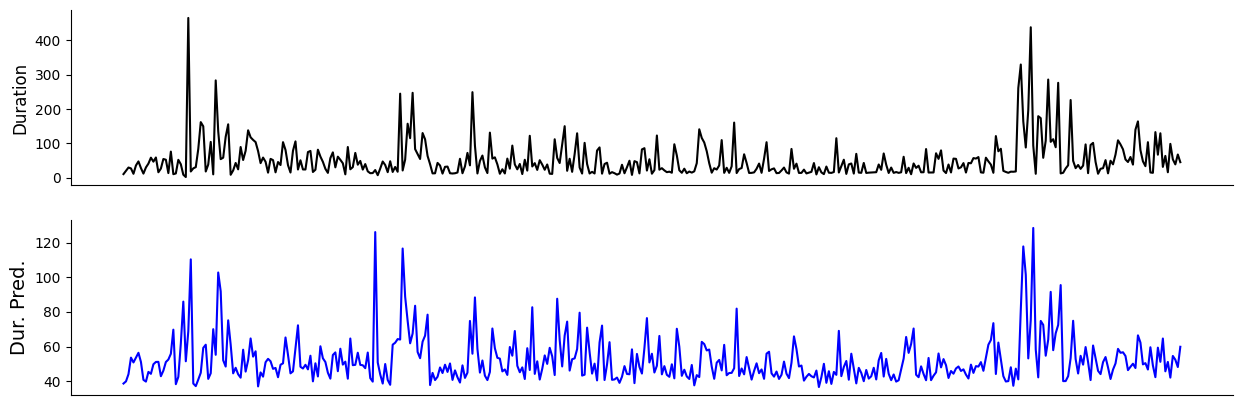

                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                  425
Model:                            GLM   Df Residuals:                      417
Model Family:                Gaussian   Df Model:                            7
Link Function:               Identity   Scale:                      1.0286e+05
Method:                          IRLS   Log-Likelihood:                -3051.5
Date:                Mon, 11 Mar 2024   Deviance:                   4.2894e+07
Time:                        14:15:52   Pearson chi2:                 4.29e+07
No. Iterations:                     3   Pseudo R-squ. (CS):            0.07582
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed                     

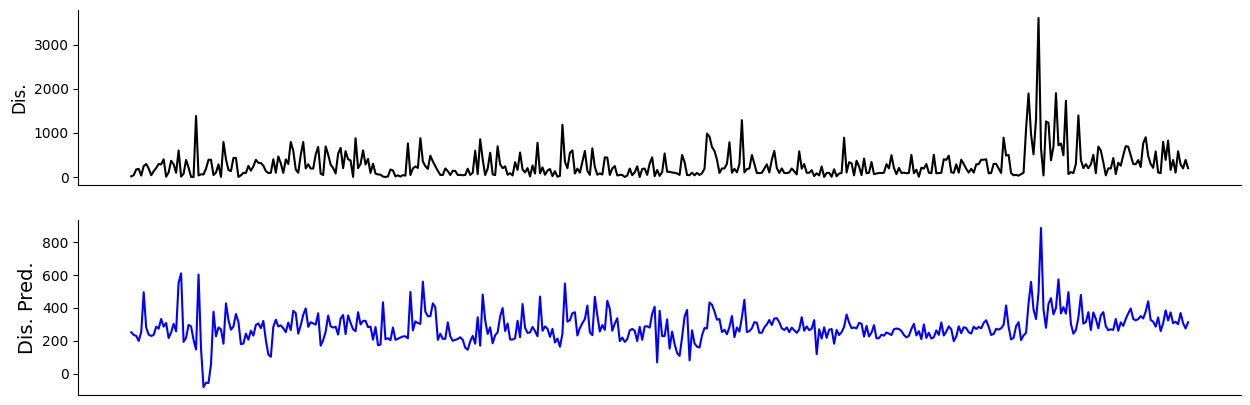

In [43]:
X = VISIT[['speed','acceleration', 'weight','PelletsInLastVisitSelf', 'PelletsInLastVisitOther', 'IntervalLastVisit' ,'entry']]
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index = X.index, columns = X.columns)
X['interc'] = 1

# Duration
Y = VISIT['duration']

model = sm.GLM(Y, X, family=sm.families.Gaussian())
result = model.fit()

print(result.summary())

y_pred = result.predict(X)

print(f"Correlation: {np.corrcoef(Y, y_pred)[0,1]}")

fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

axs[0].plot(Y.to_numpy(), color = 'black')
axs[0].set_xticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_ylabel('Duration', fontsize = 12)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[1].plot(y_pred.to_numpy(), color = 'blue')
axs[1].set_xticks([]) 
axs[1].set_facecolor('white') 
axs[1].set_ylabel('Dur. Pred.', fontsize = 14)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

plt.show()

# Distance
Y = VISIT['distance']

model = sm.GLM(Y, X, family=sm.families.Gaussian())
result = model.fit()

print(result.summary())

y_pred = result.predict(X)

print(f"Correlation: {np.corrcoef(Y, y_pred)[0,1]}")

fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

axs[0].plot(Y.to_numpy(), color = 'black')
axs[0].set_xticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_ylabel('Dis.', fontsize = 12)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[1].plot(y_pred.to_numpy(), color = 'blue')
axs[1].set_xticks([]) 
axs[1].set_facecolor('white') 
axs[1].set_ylabel('Dis. Pred.', fontsize = 14)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

plt.show()

# Poisson

                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                  425
Model:                            GLM   Df Residuals:                      417
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9244.8
Date:                Mon, 11 Mar 2024   Deviance:                       16185.
Time:                        14:40:20   Pearson chi2:                 2.17e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9429
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed                     

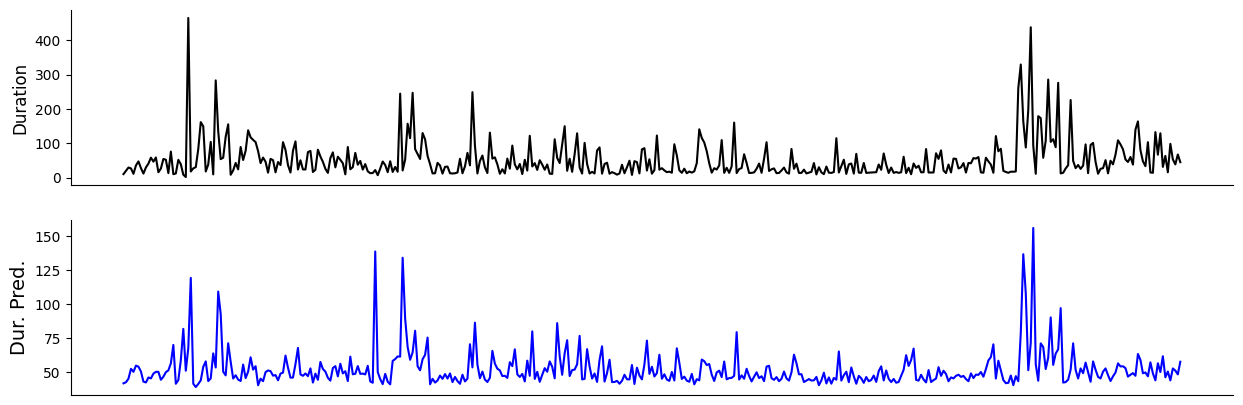

                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                  425
Model:                            GLM   Df Residuals:                      417
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -52376.
Date:                Mon, 11 Mar 2024   Deviance:                   1.0181e+05
Time:                        14:40:20   Pearson chi2:                 1.34e+05
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed                     

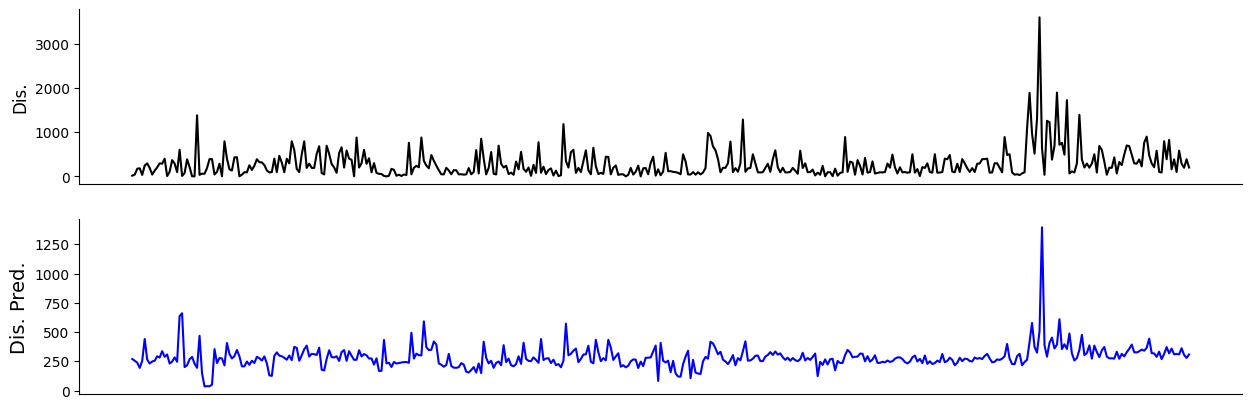

In [47]:
X = VISIT[['speed','acceleration','weight','PelletsInLastVisitSelf', 'PelletsInLastVisitOther', 'IntervalLastVisit' ,'entry']]
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index = X.index, columns = X.columns)
X['interc'] = 1

# Duration
Y = VISIT['duration']

model = sm.GLM(Y, X, family=sm.families.Poisson())
result = model.fit()

print(result.summary())

y_pred = result.predict(X)

print(f"Correlation: {np.corrcoef(Y, y_pred)[0,1]}")

fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

axs[0].plot(Y.to_numpy(), color = 'black')
axs[0].set_xticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_ylabel('Duration', fontsize = 12)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[1].plot(y_pred.to_numpy(), color = 'blue')
axs[1].set_xticks([]) 
axs[1].set_facecolor('white') 
axs[1].set_ylabel('Dur. Pred.', fontsize = 14)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

plt.show()

X = VISIT[['speed','acceleration', 'weight','PelletsInLastVisitSelf', 'PelletsInLastVisitOther', 'IntervalLastVisit','entry']]
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index = X.index, columns = X.columns)
X['interc'] = 1

# Distance
Y = VISIT['distance']

model = sm.GLM(Y, X, family=sm.families.Poisson())
result = model.fit()

print(result.summary())

y_pred = result.predict(X)

print(f"Correlation: {np.corrcoef(Y, y_pred)[0,1]}")

fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

axs[0].plot(Y.to_numpy(), color = 'black')
axs[0].set_xticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_ylabel('Dis.', fontsize = 12)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[1].plot(y_pred.to_numpy(), color = 'blue')
axs[1].set_xticks([]) 
axs[1].set_facecolor('white') 
axs[1].set_ylabel('Dis. Pred.', fontsize = 14)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

plt.show()

# For Single Sessions

ShortSession0
                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                   24
Model:                            GLM   Df Residuals:                       16
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1051.3
Date:                Mon, 11 Mar 2024   Deviance:                       1942.9
Time:                        16:23:47   Pearson chi2:                 1.83e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed       

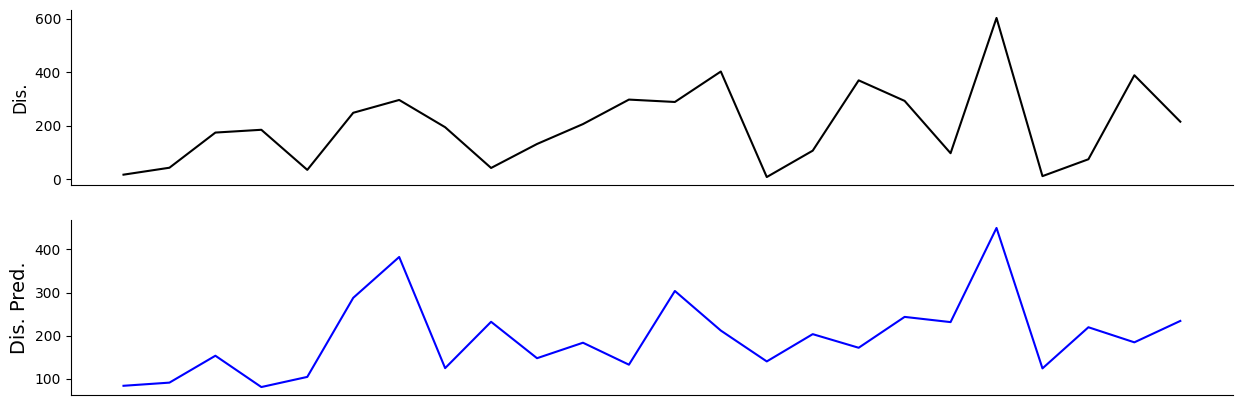

ShortSession1
                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                   12
Model:                            GLM   Df Residuals:                        4
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -374.60
Date:                Mon, 11 Mar 2024   Deviance:                       675.14
Time:                        16:23:48   Pearson chi2:                     862.
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed       

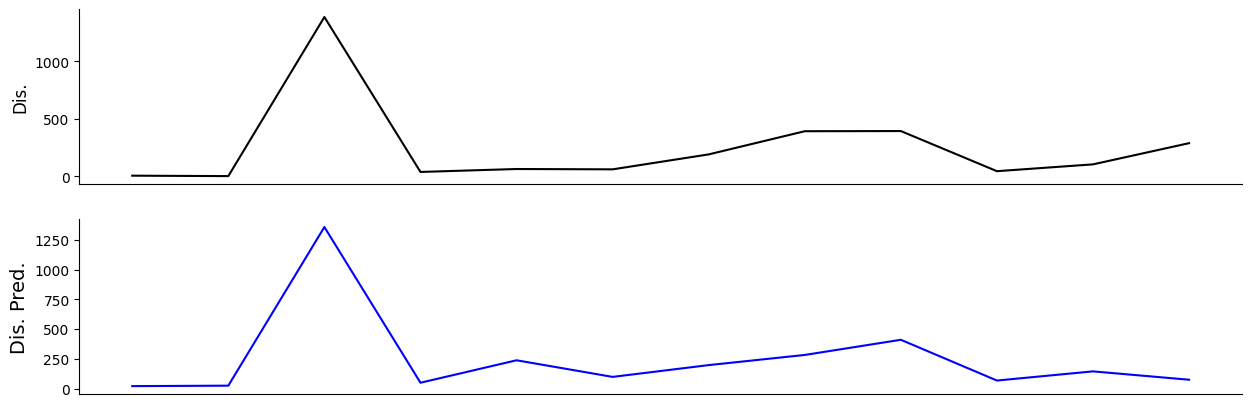

ShortSession2
                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                   21
Model:                            GLM   Df Residuals:                       13
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -820.36
Date:                Mon, 11 Mar 2024   Deviance:                       1498.7
Time:                        16:23:48   Pearson chi2:                 1.36e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed       

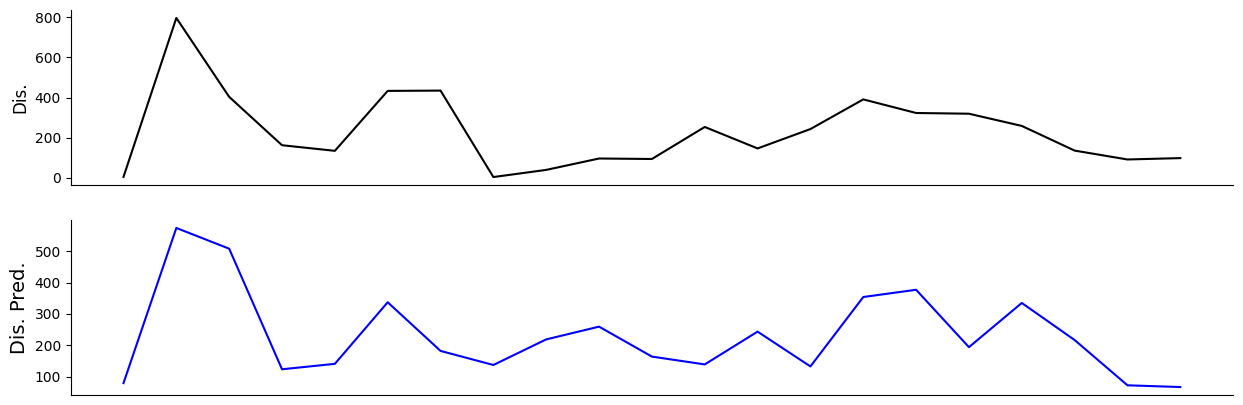

ShortSession3
                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                   21
Model:                            GLM   Df Residuals:                       13
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1291.5
Date:                Mon, 11 Mar 2024   Deviance:                       2427.6
Time:                        16:23:48   Pearson chi2:                 2.60e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed       

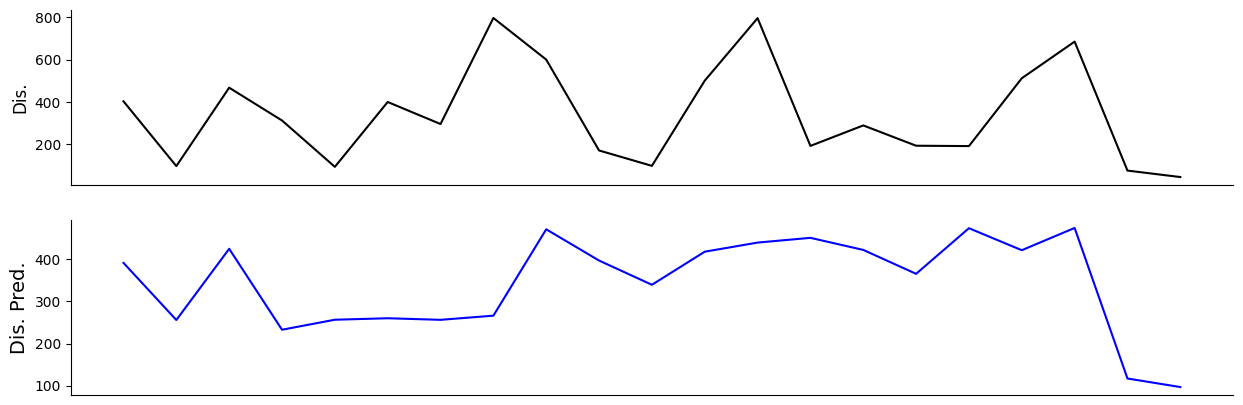

ShortSession4
                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                   23
Model:                            GLM   Df Residuals:                       15
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1143.1
Date:                Mon, 11 Mar 2024   Deviance:                       2119.3
Time:                        16:23:49   Pearson chi2:                 1.66e+03
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed       

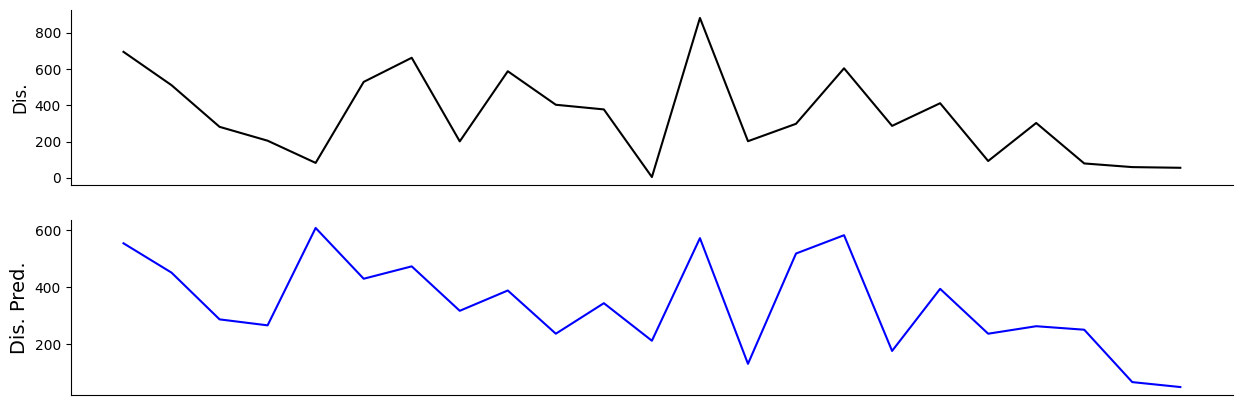

ShortSession5
                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                   13
Model:                            GLM   Df Residuals:                        5
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -685.33
Date:                Mon, 11 Mar 2024   Deviance:                       1299.9
Time:                        16:23:49   Pearson chi2:                 1.07e+09
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed       

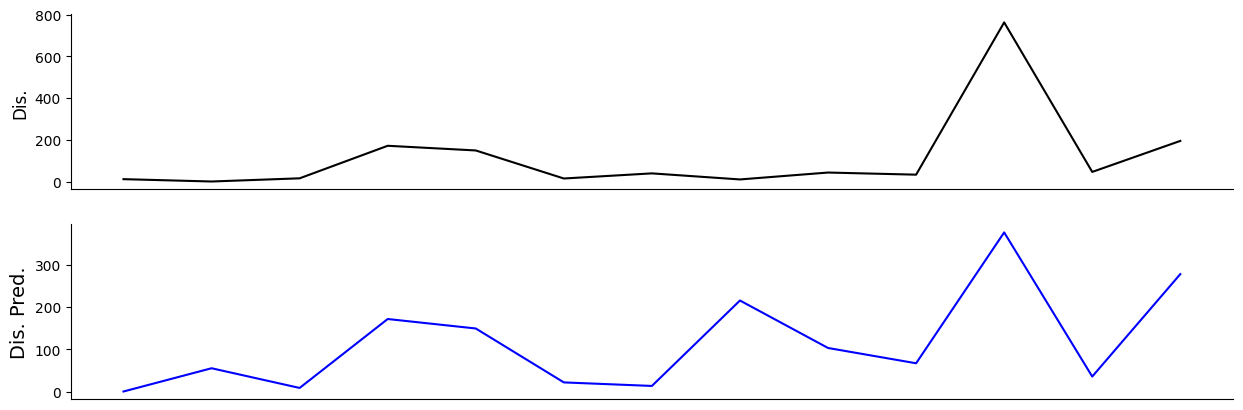

ShortSession6
                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                    9
Model:                            GLM   Df Residuals:                        2
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -115.40
Date:                Mon, 11 Mar 2024   Deviance:                       162.51
Time:                        16:23:49   Pearson chi2:                     164.
No. Iterations:                     4   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed       

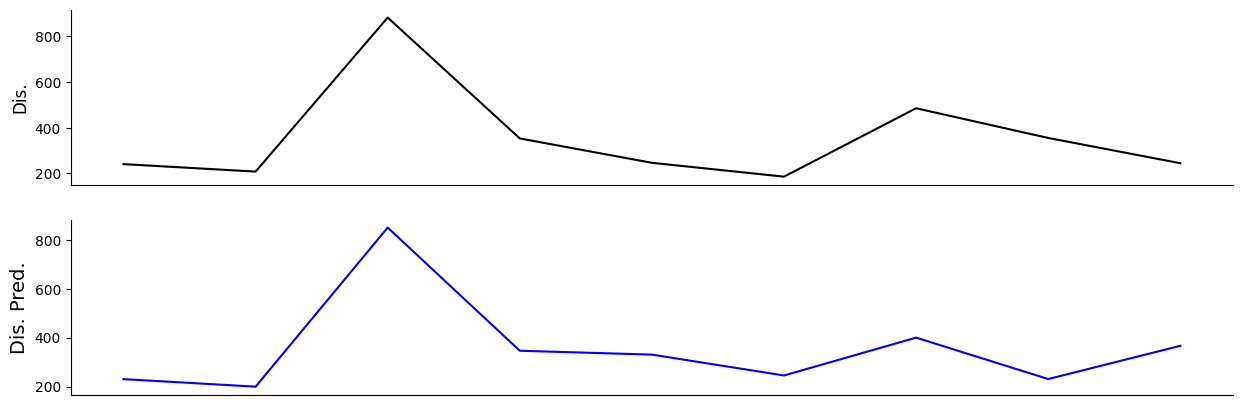

ShortSession7
                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                  106
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9090.2
Date:                Mon, 11 Mar 2024   Deviance:                       17486.
Time:                        16:23:49   Pearson chi2:                 2.08e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed       

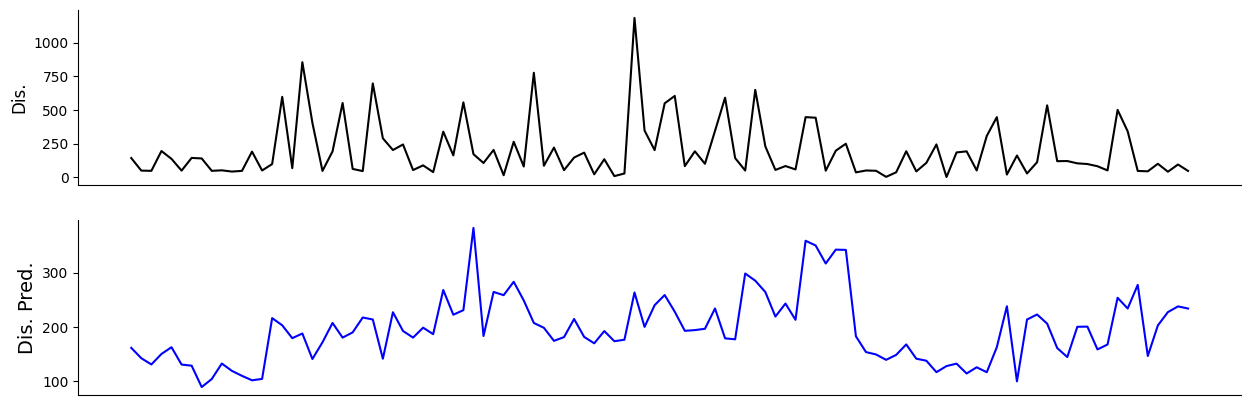

ShortSession8
                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                   57
Model:                            GLM   Df Residuals:                       49
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4713.3
Date:                Mon, 11 Mar 2024   Deviance:                       9036.0
Time:                        16:23:50   Pearson chi2:                 1.02e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed       

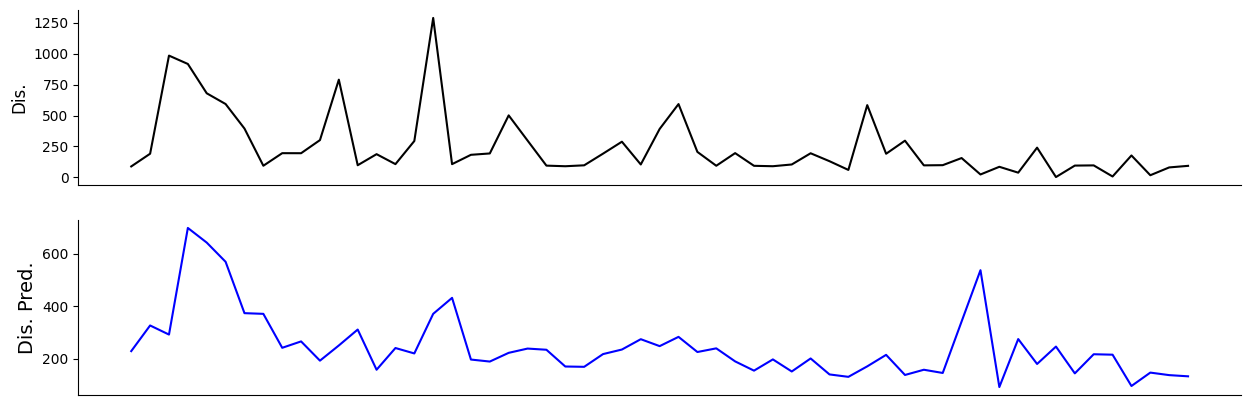

ShortSession9
                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                   73
Model:                            GLM   Df Residuals:                       65
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4449.0
Date:                Mon, 11 Mar 2024   Deviance:                       8393.7
Time:                        16:23:50   Pearson chi2:                 8.60e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed       

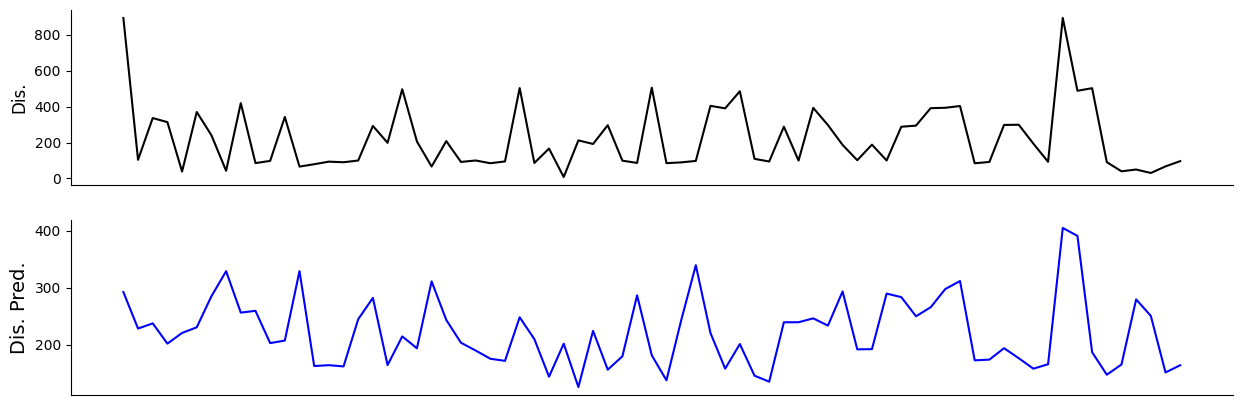

ShortSession10
                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                   18
Model:                            GLM   Df Residuals:                       11
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4997.1
Date:                Mon, 11 Mar 2024   Deviance:                       9842.7
Time:                        16:23:50   Pearson chi2:                 1.01e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed      

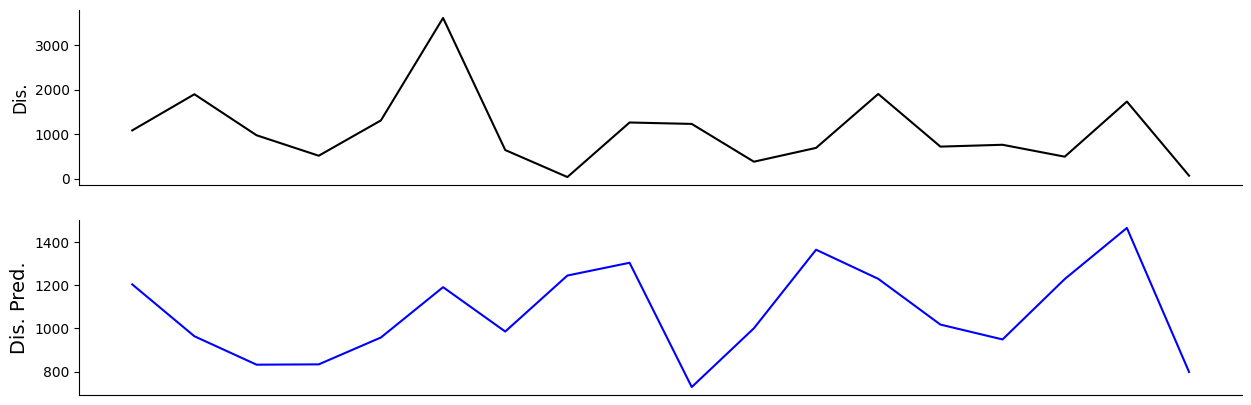

ShortSession11
                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                   48
Model:                            GLM   Df Residuals:                       41
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3486.8
Date:                Mon, 11 Mar 2024   Deviance:                       6611.9
Time:                        16:23:50   Pearson chi2:                 7.18e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed      

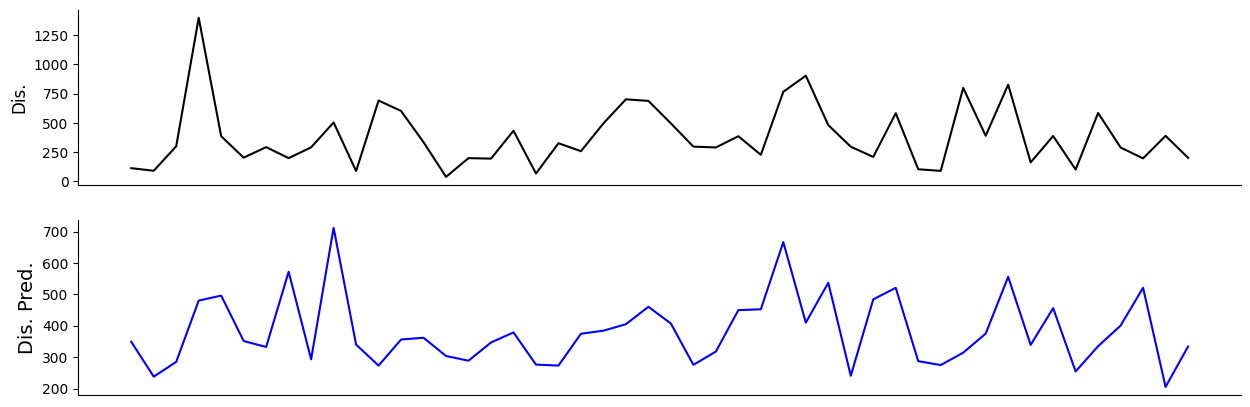

In [7]:
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(i)
    print(title)

    Visits_Patch1 = pd.read_parquet(title+'Visit1.parquet', engine='pyarrow')
    Visits_Patch2 = pd.read_parquet(title+'Visit2.parquet', engine='pyarrow')

        
    VISIT = pd.concat([Visits_Patch1,Visits_Patch2], ignore_index=False)
    VISIT = VISIT[VISIT['distance'] >= 0.1]

    X = VISIT[['speed','acceleration','weight','PelletsInLastVisitSelf', 'PelletsInLastVisitOther', 'IntervalLastVisit' ,'entry']]
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), index = X.index, columns = X.columns)
    X['interc'] = 1


    # Distance
    Y = VISIT['distance']

    model = sm.GLM(Y, X, family=sm.families.Poisson())
    result = model.fit()

    print(result.summary())

    y_pred = result.predict(X)

    print(f"Correlation: {np.corrcoef(Y, y_pred)[0,1]}")

    fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

    axs[0].plot(Y.to_numpy(), color = 'black')
    axs[0].set_xticks([]) 
    axs[0].set_facecolor('white') 
    axs[0].set_ylabel('Dis.', fontsize = 12)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)

    axs[1].plot(y_pred.to_numpy(), color = 'blue')
    axs[1].set_xticks([]) 
    axs[1].set_facecolor('white') 
    axs[1].set_ylabel('Dis. Pred.', fontsize = 14)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)

    plt.show()

# Tweedie

                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                  425
Model:                            GLM   Df Residuals:                      417
Model Family:                 Tweedie   Df Model:                            7
Link Function:                    Log   Scale:                          6.8961
Method:                          IRLS   Log-Likelihood:                -2158.4
Date:                Mon, 11 Mar 2024   Deviance:                       2099.8
Time:                        10:58:23   Pearson chi2:                 2.88e+03
No. Iterations:                    16   Pseudo R-squ. (CS):            0.05885
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed                     

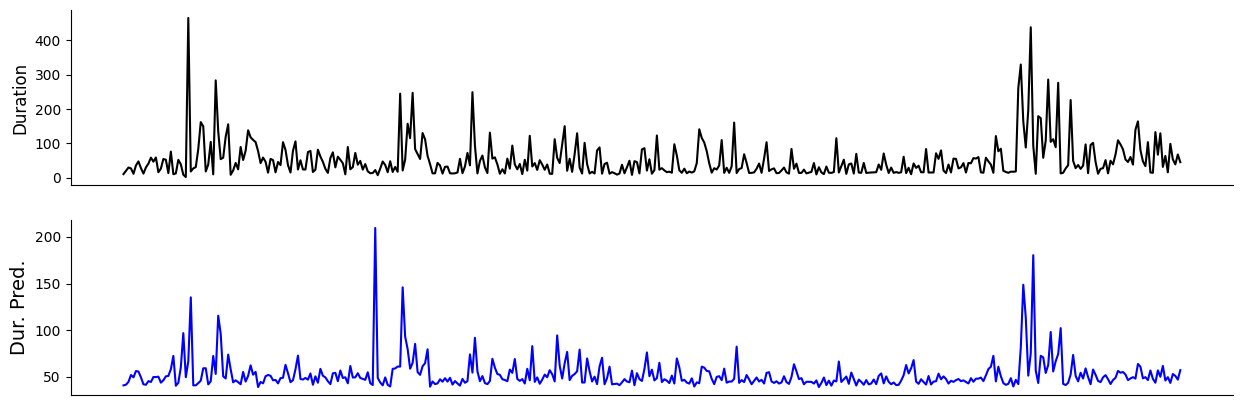

                 Generalized Linear Model Regression Results                  
Dep. Variable:               distance   No. Observations:                  425
Model:                            GLM   Df Residuals:                      417
Model Family:                 Tweedie   Df Model:                            7
Link Function:                    Log   Scale:                          18.298
Method:                          IRLS   Log-Likelihood:                -2900.3
Date:                Mon, 11 Mar 2024   Deviance:                       6181.6
Time:                        10:58:23   Pearson chi2:                 7.63e+03
No. Iterations:                    27   Pseudo R-squ. (CS):            0.08030
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
speed                     

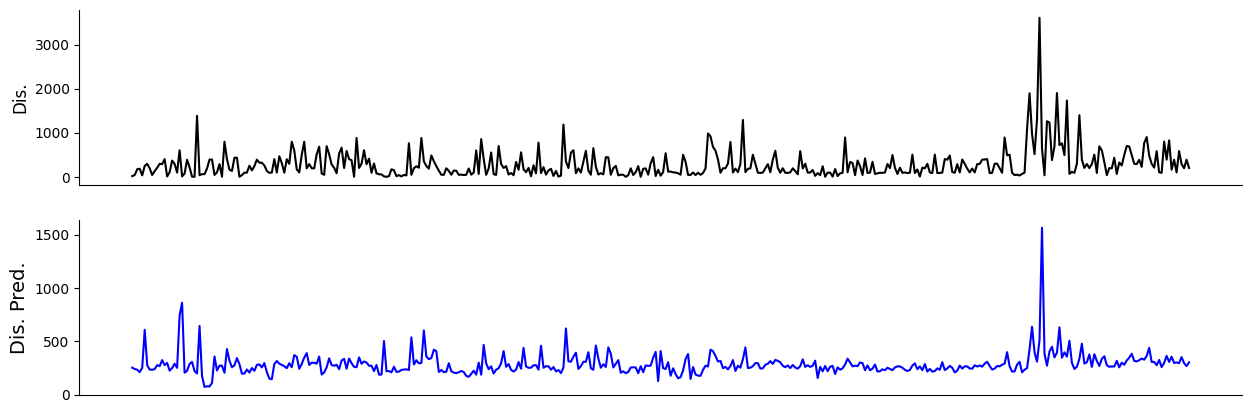

In [29]:
X = VISIT[['speed','acceleration', 'weight','PelletsInLastVisitSelf', 'PelletsInLastVisitOther', 'IntervalLastVisit' ,'entry','interc']]

# Duration
Y = VISIT['duration']

model = sm.GLM(Y, X, family=sm.families.Tweedie(var_power=1.5))
result = model.fit()

print(result.summary())

y_pred = result.predict(X)

print(f"Correlation: {np.corrcoef(Y, y_pred)[0,1]}")

fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

axs[0].plot(Y.to_numpy(), color = 'black')
axs[0].set_xticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_ylabel('Duration', fontsize = 12)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[1].plot(y_pred.to_numpy(), color = 'blue')
axs[1].set_xticks([]) 
axs[1].set_facecolor('white') 
axs[1].set_ylabel('Dur. Pred.', fontsize = 14)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

plt.show()

# Distance
Y = VISIT['distance']

model = sm.GLM(Y, X, family=sm.families.Tweedie(var_power=1.5))
result = model.fit()

print(result.summary())

y_pred = result.predict(X)

print(f"Correlation: {np.corrcoef(Y, y_pred)[0,1]}")

fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

axs[0].plot(Y.to_numpy(), color = 'black')
axs[0].set_xticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_ylabel('Dis.', fontsize = 12)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[1].plot(y_pred.to_numpy(), color = 'blue')
axs[1].set_xticks([]) 
axs[1].set_facecolor('white') 
axs[1].set_ylabel('Dis. Pred.', fontsize = 14)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

plt.show()